# Creating a Waffle Chart with Python
## Use Case
I needed a way to show how much of each category made up of a whole in terms of costs in a Power BI report.

### Limitations:
1. The number of categories was excessive so the built in charts would have made it hard to read.
2. Power BI Service only supports a handful of python packages. So using a niche package to generate it wouldnt work when the report is published to the Power BI service for the end user.

In [1]:
%precision %.2f

'%.2f'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
import re

## Sample Data

(Skip to **_Visualizing the Whole_** if you already have data)

Create a set of sample categories, 20 in this case.

In [3]:
categories = [f'Category {x+1}' for x in range(20)]
categories

['Category 1',
 'Category 2',
 'Category 3',
 'Category 4',
 'Category 5',
 'Category 6',
 'Category 7',
 'Category 8',
 'Category 9',
 'Category 10',
 'Category 11',
 'Category 12',
 'Category 13',
 'Category 14',
 'Category 15',
 'Category 16',
 'Category 17',
 'Category 18',
 'Category 19',
 'Category 20']

Create a set of 20 random integer values that follow a pareto distribution.

A pareto distribution gets us a dataset that has a few larger numbers and the rest trail off which would be analgous to a business case of "Costs by Category".

Example pareto distributions (Wikipedia):
![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fupload.wikimedia.org%2Fwikipedia%2Fcommons%2Fthumb%2F1%2F11%2FProbability_density_function_of_Pareto_distribution.svg%2F1920px-Probability_density_function_of_Pareto_distribution.svg.png&f=1&nofb=1)

In [4]:
costs = np.rint(np.random.pareto(1,20) * 1000)
costs

array([9.9200e+02, 4.0000e+00, 2.2820e+03, 2.9960e+03, 6.3600e+02,
       2.4913e+04, 1.0000e+02, 8.5000e+02, 1.8025e+04, 5.8460e+03,
       1.8300e+02, 5.2200e+02, 4.2600e+02, 8.0500e+02, 4.4410e+03,
       3.5930e+03, 2.8800e+02, 1.7040e+03, 5.9100e+02, 5.9910e+03])

### What does the Sample Data look like?

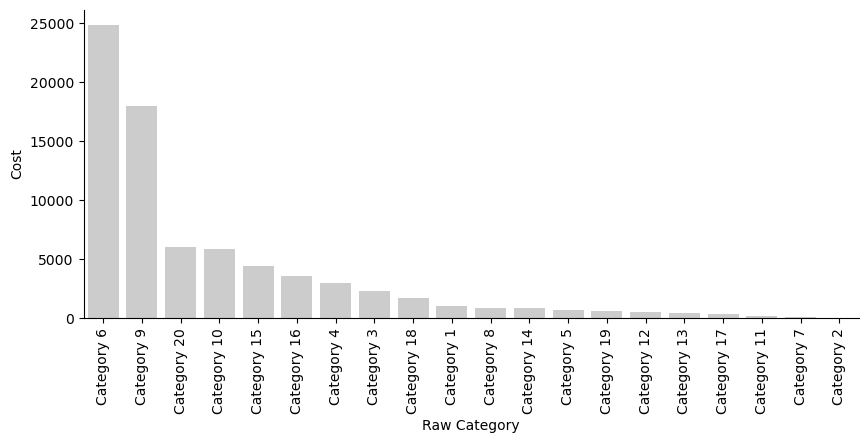

In [5]:
data = pd.DataFrame({'Raw Category': categories, 'Cost':costs}).sort_values(by='Cost', ascending=False)

f, ax = plt.subplots(figsize=(10,4))
ax = sns.barplot(x='Raw Category', y='Cost', data=data, color='#CCC')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
sns.despine()
plt.show()

---
## Visualizing the Whole
### *Waffle > Pie*

We need to keep in mind a few important points when it comes to building out the visualization.
- The brain tends to struggle when you go beyond half a dozen categories. 
- Color needs to be reserved for impact, it should have meaning and draw attention. (Note, this isnt always easy to do.)
- Pie charts add to the mental load of discerning arc's and areas and when values are close its near impossible to tell which value is larger.

So what are things we need to do to address the above?
1. Leave the top 5 categories alone so they are broken out, but bucket the rest into an **_Other_** category.
2. Avoid the default colors. Use shades of a neutral color or a set of muted colors.
3. Ditch the pie chart and build a **_Waffle_** Chart

### Defining a few parameters

In [6]:
W = 20  # Width
H = 5  # Height
TOPN = 5  # How many categories to keep broken out

nwaffle = W * H  # Waffle Sections

### Creating the 'Other' bucket

In [7]:
data.head()

,Raw Category,Cost
5,Category 6,24913.0
8,Category 9,18025.0
19,Category 20,5991.0
9,Category 10,5846.0
14,Category 15,4441.0


In [8]:
total = data['Cost'].sum()
data['pct_raw'] = data['Cost'].apply(lambda x: x / total)
data['rank_raw'] = data['Cost'].rank(ascending=False)
data['Category'] = data.apply(lambda x: 'Other' if x['rank_raw'] > TOPN else x['Raw Category'], axis=1)
data['Sort ID'] = data['rank_raw'].apply(lambda x: TOPN + 1 if x > TOPN else x)
data

,Raw Category,Cost,pct_raw,rank_raw,Category,Sort ID
5,Category 6,24913.0,0.331343,1.0,Category 6,1.0
8,Category 9,18025.0,0.239732,2.0,Category 9,2.0
19,Category 20,5991.0,0.079680,3.0,Category 20,3.0
9,Category 10,5846.0,0.077752,4.0,Category 10,4.0
14,Category 15,4441.0,0.059065,5.0,Category 15,5.0
15,Category 16,3593.0,0.047787,6.0,Other,6.0
3,Category 4,2996.0,0.039847,7.0,Other,6.0
2,Category 3,2282.0,0.030351,8.0,Other,6.0
17,Category 18,1704.0,0.022663,9.0,Other,6.0
0,Category 1,992.0,0.013194,10.0,Other,6.0


### Data --> Graph Data

To get the dataset ready to graph we need to do a few small steps:
1. Aggregate the data. We need to sum the cost and 'pct_raw' for each of the new categories, and get the **_min_** Sort ID.
2. Get an integer number of how many tiles each category represents.
3. Sort the values so they graph in a meaningful way.

In [9]:
dfg = data.groupby(by=['Category']).agg({'Cost':'sum', 'pct_raw':'sum', 'Sort ID':'min'})
dfg['tiles'] = round(dfg.pct_raw * nwaffle)
dfg.sort_values('Sort ID', inplace=True)
dfg

,Cost,pct_raw,Sort ID,tiles
Category,,,,
Category 6,24913.0,0.331343,1.0,33.0
Category 9,18025.0,0.239732,2.0,24.0
Category 20,5991.0,0.079680,3.0,8.0
Category 10,5846.0,0.077752,4.0,8.0
Category 15,4441.0,0.059065,5.0,6.0
Other,15972.0,0.212428,6.0,21.0


In [10]:
dfg.tiles.sum()

100.0

Sometimes the tiles dont total what you set the graph to (that **nwaffle** number) due to rounding. In this case, one solution is to increment the **Other** bucket by 1 tile.

In [11]:
if sum(dfg.tiles) == (nwaffle - 1):
    dfg.loc['Other', 'tiles'] +=1
dfg

,Cost,pct_raw,Sort ID,tiles
Category,,,,
Category 6,24913.0,0.331343,1.0,33.0
Category 9,18025.0,0.239732,2.0,24.0
Category 20,5991.0,0.079680,3.0,8.0
Category 10,5846.0,0.077752,4.0,8.0
Category 15,4441.0,0.059065,5.0,6.0
Other,15972.0,0.212428,6.0,21.0


Now we have the dataset to build the graph from.

---
## Building the Waffle

In [12]:
# Creating basic arrays of each column we need
categories = dfg.index.values
tiles = dfg.tiles.values
costs = dfg.Cost.values

waffle = np.zeros((H, W))  # Builds an array of zeros as a basis of the chart in the dimensions we defined earlier

indx_cat = 0
indx_tile = 0

# Walk the Waffle
for col in range(W):
    for row in range(H):
        indx_tile += 1
        if indx_tile > sum(tiles[0:indx_cat]):
            indx_cat += 1
        waffle[row, col] = indx_cat

In [28]:
# Somewhat muted colors that are easy to distinguish between
color_codes = ["#0083BF","#82894d","#4d4e21","#b77b1d","#a14119","#CCC"]

In [26]:
# Grayscale colors
#color_codes = ['#bababa', '#d0d0d0', '#5e5e5e', '#808080', '#9e9e9e', '#323232']

In [21]:
# Grayscale with an attention getter
#  https://projects.susielu.com/viz-palette
#color_codes = ['#bababa', '#d0d0d0', '#5e5e5e', '#808080', '#9e9e9e', '#b77b1d']

In [15]:
params = {'figure.dpi': 300,         
        'legend.fontsize': 'x-large'
         }
mpl.rcParams.update(params)

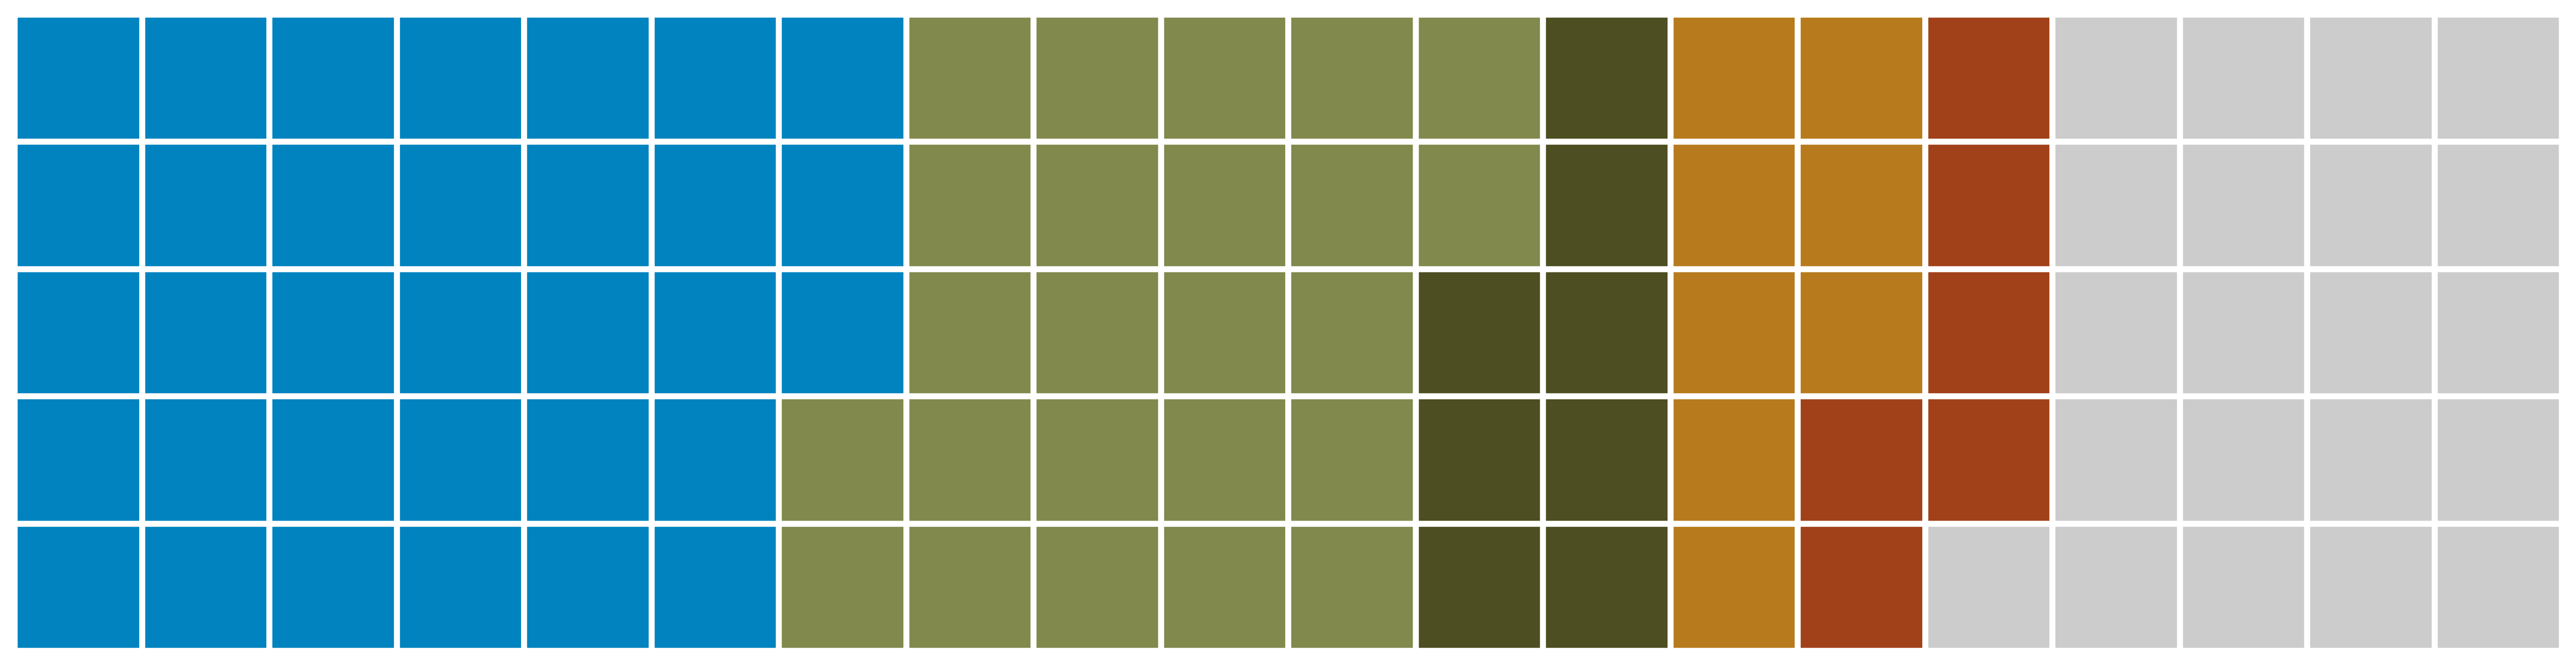

In [30]:
colormap = mpl.colors.ListedColormap(color_codes)

def format_str(s, max_len:int = 8):
    idx_spaces = [m.start() for m in re.finditer(" ", s)]
    lim = max_len
    for idx in idx_spaces:
        if idx < lim:
            pass
        else:
            if idx == lim:
                s = s[:lim] + '\n' + s[lim+1:]
            else:
                s = s[:idx] + '\n' + s[idx+1:]
    return s

f, ax = plt.subplots(figsize=(18,6))
ax.imshow(waffle, cmap=colormap)

ax.set_xticks(np.arange(-0.5, W, 1), minor=True)
ax.set_yticks(np.arange(-0.5, H, 1), minor=True)

ax.grid(which='minor', color='w', ls='-', lw=3)

plt.xticks([])
plt.yticks([])

legend_handles = []

for i, cat in enumerate(categories):
    label_str = f'{format_str(cat)}\n(${costs[i]/1000:0,.1f}K)'.replace(" ","\n")
    color_val = color_codes[i]
    #legend_handles.append(mpatches.Patch(color=color_val, label=label_str))
    legend_handles.append(mpl.lines.Line2D([0],[0], color='w', label=label_str, marker='o', markerfacecolor=color_val, markersize=42))

leg = plt.legend(handles=legend_handles, loc='lower center', ncol=len(categories), bbox_to_anchor=(0,-0.27,1,1), frameon=False)

ax.tick_params(axis='x', which='both', colors='w')
ax.tick_params(axis='y', which='both', colors='w')
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.show()